# Support Vector Machine

A *Support Vector machine* (SVM) is a very powerful and versatile supervised machine learning model, capable of performing linear or nonlinear classification and regression tasks. To separate the two classes of data points, there are many possible hyperplanes that could be chosen. The key idea behind SVM is that the algorithm finds an optimal hyperplane that has the **maximum margin**, i.e the maximum distance between data points of both classes. 

<!--<img src="svm_hyperplanes.png" alt="drawing" width="600"/>-->

This fundamental idea is explained with the plots above. The plot on the left shows many hyperplanes that can separate the circles from the squares. These hyperplanes work perfectly on this training dataset, but their decision boundaries come so close to the instances that they will probably not perform as well on new instances.  However, the right plot shows the optimal hyperplane that maximize the margin between these two classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.

In this lab assignment, you will learn to use and fine-tune linear SVM, the Polynomial kernel SVM and the RBF kernel SVM, and understand their pros and cons by comparing their prediction performance on a synthetic dataset.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# make this notebook's output stable across runs
np.random.seed(0)

In [2]:
# helper functions used in this lab
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    """
    Plot the decision boundary of a learnt classifier
    """
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=1)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
def evaluate_model(model, X, y):
    # make prediction and evaluate the model performance on test data
    z = model.predict(X)
    z_prob = model.predict_proba(X)[:,1]

    print("model accuracy: {}".format(accuracy_score(y, z)))
    print("model ROC AUC: {}".format(roc_auc_score(y, z_prob)))

### Synthetic Moon dataset
In this lab, we will classify a moon shaped synthetic dataset with two features (_x1_ and _x2_) and two classes (0 or 1) with some added noise. We use this synthetic dataset because it's easier to help demonstrate the pros and cons of different SVM models covered in this lab.

In [3]:
# load the moon train and test data from CSV files
train = pd.read_csv("moon_train.csv")
test = pd.read_csv("moon_test.csv")

train_x = train.iloc[:,0:2]
train_y = train.iloc[:,2]

test_x = test.iloc[:,0:2]
test_y = test.iloc[:,2]

print("Number of train data: {}".format(len(train_y)))
print("Number of test data: {}".format(len(test_y)))

Number of train data: 3000
Number of test data: 1000


Text(0, 0.5, 'x2')

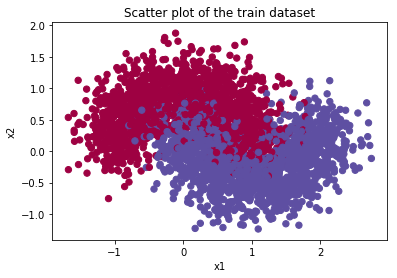

In [4]:
# plot the train dataset
plt.scatter(train_x.x1, train_x.x2, s=40, c=train_y, cmap=plt.cm.Spectral)
plt.title('Scatter plot of the train dataset')
plt.xlabel('x1')
plt.ylabel('x2')

Text(0, 0.5, 'x2')

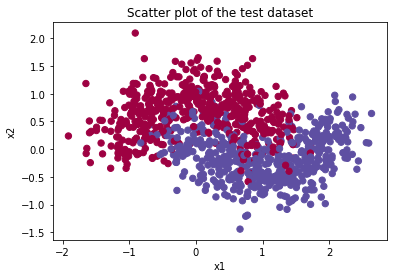

In [5]:
# plot the test dataset
plt.scatter(test_x.x1, test_x.x2, s=40, c=test_y, cmap=plt.cm.Spectral)
plt.title('Scatter plot of the test dataset')
plt.xlabel('x1')
plt.ylabel('x2')

## Linear SVM

<span style="color:orange">**Coding Part 1: Learn to use and fine-tune the Linear Support Vector Machine.**</span> 

### Pipeline

Unlike tree-based models (e.g. CART, Random Forest and Gradient Boosted Trees), SVMs are sensitive to the feature scales. It is best practice to apply feature scaling with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function in scikit-learn. 

[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) in scikit-learn allows us to sequentially apply a list of transformations and a final estimator. For example, in the following code we first apply the feature scaling before feeding the data to train a linear SVM model. Note that you need to set the argument _probability_ to be True so that the SVC model outputs probabilities as well as the predictions.

In [6]:
# define the pipeline
linear_svc_pipe = Pipeline(
    (
        ("scaler", StandardScaler()),
        ("csv", SVC(kernel="linear", probability=True, random_state=0))
    )
)
linear_svc_pipe.fit(train_x, train_y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('csv', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False))])

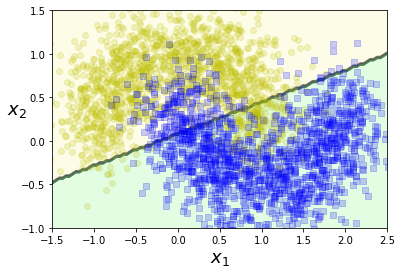

In [7]:
# plot the decision boundary
plot_decision_boundary(linear_svc_pipe, train_x.values, train_y.values, alpha=0.2)

As we can see from the plot above, a linear SVM can produce only a linear hyperplane as the decision boundary and is not capable of modeling this moon-shaped dataset and generating the decision boundaries close to the ground truth.    

In [8]:
# make prediction and evaluate the model performance on test data
evaluate_model(linear_svc_pipe, test_x, test_y)

model accuracy: 0.839
model ROC AUC: 0.9256840000000002


#### Penalty parameter C

SVM's objective function consists of two terms: the first term measures how large the margin is (we want to maximize the margin, which corresponds to minimizing $W^T W$ in the follow equation), and the second term measures the violations of the hyperplane ($\sum_i^m \xi^i$). This is where the hyper-parameter $C$ comes in. It is used to tradeoff between these two objectives.  

\begin{align}
\min_{W, b} \frac{1}{2}W^T W & + C \sum_i^m \xi^i \\
S.T. y^i (W^T X^i + b) & \geqslant 1 - \xi^i \\
\xi^i & \geqslant 0
\end{align}

In [10]:
# Use grid search with cross-validation on penalty parameter C to fine-tune the SVC model.
#       Note that you need to set probability to be True so that the trained model outputs both predictions as well as probabilities.
parameters = {
    "C": [0.01, 0.1, 1, 10, 100]
}

linear_svc_grid = GridSearchCV(SVC(probability=True, random_state=0, gamma="auto"), parameters, cv=5, iid=True)

# define the pipeline
linear_svc_grid_pipe = Pipeline(
    (
        ("scaler", StandardScaler()),
        ("csv", linear_svc_grid)
    )
)
linear_svc_grid_pipe.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(linear_svc_grid.best_score_))
print("The best hyper parameter setting is {}".format(linear_svc_grid.best_params_))

The best score is 0.909
The best hyper parameter setting is {'C': 10}


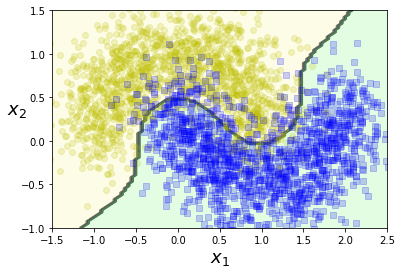

In [11]:
# plot the decision boundary
plot_decision_boundary(linear_svc_grid_pipe, train_x.values, train_y.values, alpha=0.2)

After fine-tuning the model, we should see the model performance improve slightly as compared to the SVC with the default setting. 

In [12]:
evaluate_model(linear_svc_grid_pipe, test_x, test_y)

model accuracy: 0.902
model ROC AUC: 0.9567559999999999


---

## Polynomial Kernel SVM

<span style="color:orange">**Coding Part 2: Understand the limitation of linear SVM and learn how to use kernel trick to extend linear SVM to handle non-linear scenarios.**

### Polynomial Features 

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not linearly separable. One approach to handling nonlinear datasets is to add more non-linear features, such as polynomial features, and hope the dataset is linear separable in the higher dimensional space with the help of non-linear features. 

In the following example, we apply polynomial functions with degree of 3 to the original features before feeding the data to the linear SVC.

In [15]:
poly_feature_svm_pipe = Pipeline(
    (
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="linear", probability=True))
    )
)
poly_feature_svm_pipe.fit(train_x, train_y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

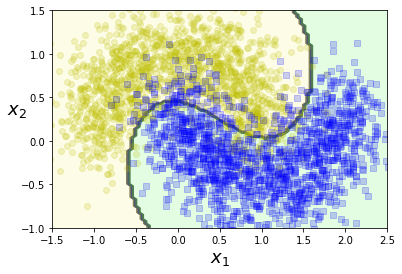

In [17]:
# plot the decision boundary
plot_decision_boundary(poly_feature_svm_pipe, train_x.values, train_y.values, alpha=0.2)

In [18]:
# make prediction and evaluate the model performance on test data
evaluate_model(poly_feature_svm_pipe, test_x, test_y)

model accuracy: 0.903
model ROC AUC: 0.964178


### Polynomial SVM
Instead of explicitly applying the polynomial functions to each data point, kernel trick allows us to get the same result as if you added many polynomial features (even with very high-degree polynomials) without actually having to add them to each data point. So the number of features won't grow combinatorially. 

To train the SVC with polynomial kernel, we need to specify argument _kernel_ to be "poly". Like linear SVC, we need to fine tune the penalty parameter *C* to tradeoff minimizing margin and minimizing violations. Also, we need to specify the degree of the polynomial functions as well as a hyper-parameter _coef0_ which controls how much the model is influenced by high-degree polynomials vs. low-degree polynomials. Please refer to the [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) API doc for more details.

In [13]:
# Use grid search with cross-validation on penalty parameter C, polynomial degree, and coef0 to 
#       fine-tune the model. 
parameters = {
    "C": [0.1, 1, 10],
    "degree": [3, 5],
    "coef0": [0.5, 1.0]
}
poly_svc_grid = GridSearchCV(SVC(kernel="poly",probability=True, random_state=0, gamma="auto"), parameters, cv=5, iid=True) 

# define the pipeline
poly_svc_grid_pipe = Pipeline(
    (
        ("scaler", StandardScaler()),
        ("csv", poly_svc_grid)
    )
)
poly_svc_grid_pipe.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(poly_svc_grid.best_score_))
print("The best hyper parameter setting is {}".format(poly_svc_grid.best_params_))

The best score is 0.908
The best hyper parameter setting is {'C': 10, 'coef0': 0.5, 'degree': 3}


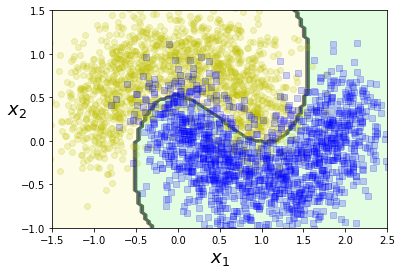

In [20]:
# plot the decision boundary
plot_decision_boundary(poly_svc_grid_pipe, train_x.values, train_y.values, alpha=0.2)

In [21]:
# make prediction and evaluate the model performance on test data
evaluate_model(poly_svc_grid_pipe, test_x, test_y)

model accuracy: 0.906
model ROC AUC: 0.964122


Both the polynomial SVC and adding polynomial features in a linear SVC result in very similar performance and significantly improve the model performance on the test dataset. The decision boundaries are no longer linear in the original feature space and better capture the ground truth of this moon-shaped dataset.

## Gaussian Radial Basis Function (RBF) SVM 
<span style="color:orange">**Coding Part 3: Learn to use Gaussian Radial Basis Function (RBF) SVM.**

Another very popular kernel used in SVM is called the Gaussian Radial Basis Function (RBF) kernel. The idea of RBF kernel is to allow each training instance to resemble a particular landmark. The RBF kernel on two samples x and x', represented as feature vectors in some input space, is defined as

\begin{align}
K(x, x') = \exp(-\gamma||x - x'||^2)
\end{align}

RBF Kernel has a hyper-parameter $\gamma$, which controls the shape of the Gaussian function. The parameter $\gamma$ is the inverse of the standard deviation of the RBF kernel (Gaussian function), which is used as similarity measure between two points. Intuitively, a small gamma value define a Gaussian function with a large variance. In this case, two points can be considered similar even if are far from each other. In the other hand, a large gamma value means define a Gaussian function with a small variance and in this case, two points are considered similar just if they are close to each other.

To demonstrate this effect of hyper-parameter $\gamma$, we train two separate SVCs, one with a large value of $\gamma$ and one with a small value of $\gamma$.

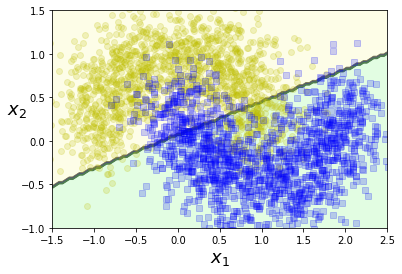

In [23]:
# train RBF SVC with a small gamma and underfit the training set
rbf_svc_pipe = Pipeline(
    (
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", gamma=0.01, probability=True))
    )
)
rbf_svc_pipe.fit(train_x, train_y)
plot_decision_boundary(rbf_svc_pipe, train_x.values, train_y.values, alpha=0.2)

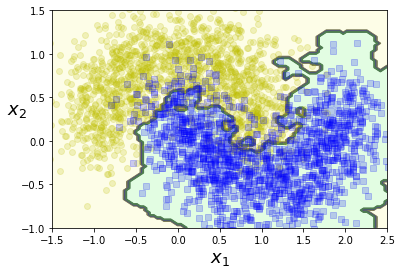

In [24]:
# train RBF SVC with a large gamma and overfit the training set
rbf_svc_pipe = Pipeline(
    (
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", gamma=100, probability=True))
    )
)
rbf_svc_pipe.fit(train_x, train_y)
plot_decision_boundary(rbf_svc_pipe, train_x.values, train_y.values, alpha=0.2)

As we can see from the previous two plots, $\gamma$ acts like a regularization hyper-parameter. A small value of $\gamma$ leads to model underfitting (the upper figure) and a large value of $\gamma$ leads to model overfitting (the lower figure). Like other hyper-parameters, the value of $\gamma$ needs to be fine-tuned with a validation set.

In [15]:
# Use grid search with cross-validation on penalty parameter C to fine-tune the model
parameters = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [0.1, 1, 10, 100]
}
rbf_svc_grid = rbf_svc_grid = GridSearchCV(SVC(kernel="rbf", probability=True, random_state=0), parameters, cv=5, iid=True)

# define the pipeline
rbf_svc_grid_pipe = Pipeline(
    (
        ("scaler", StandardScaler()),
        ("csv", rbf_svc_grid)
    )
)
rbf_svc_grid_pipe.fit(train_x, train_y) 

# summarize the results of the grid search
print("The best score is {}".format(rbf_svc_grid.best_score_))
print("The best hyper parameter setting is {}".format(rbf_svc_grid.best_params_))

The best score is 0.911
The best hyper parameter setting is {'C': 10, 'gamma': 10}


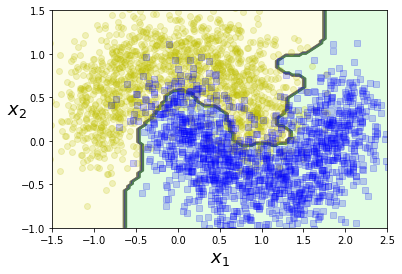

In [16]:
# plot the decision boundary
plot_decision_boundary(rbf_svc_grid_pipe, train_x.values, train_y.values, alpha=0.2)

In [27]:
# make prediction and evaluate the model performance on test data
evaluate_model(rbf_svc_grid_pipe, test_x, test_y)

model accuracy: 0.893
model ROC AUC: 0.9243999999999999


### End of ML 310 Lab Assignment 4
---